# Pronostico de la evolución del PIB en las cuatro economías más grandes de Latinoamérica

La economía de América Latina ha sido objeto de atención y estudio durante décadas debido a su importancia a nivel mundial. Las cuatro principales economías de la región, Brasil, México, Argentina y Colombia, tienen un impacto significativo en la economía global, tanto en términos de producción como de comercio. En este contexto, el Producto Interno Bruto (PIB) es una medida clave de la salud económica de un país, ya que refleja el valor total de los bienes y servicios producidos en un año.

En este estudio, se presentará una proyección del PIB de las cuatro economías más grandes de Latinoamérica, utilizando modelos de predicción de series de tiempo de la familia ARMA. Estos modelos han demostrado ser efectivos para predecir la evolución del PIB, ya que tienen en cuenta tanto la tendencia como la estacionalidad de los datos.

Los datos utilizados para este análisis abarcan desde el año 1960 hasta 2021, lo que nos permite obtener una visión general de la evolución histórica del PIB de estas economías

Este estudio tiene como objetivo ofrecer una proyección del PIB de las principales economías de Latinoamérica, con el fin de proporcionar información valiosa para los responsables de la toma de decisiones, inversores y otros actores económicos interesados en la región.

## Librerias

In [1]:
! pip install arch -q
! pip install pmdarima -q

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
from arch.unitroot import PhillipsPerron , KPSS , ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tools.eval_measures import rmse ,mse
from pmdarima import auto_arima

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importacion de los datos

Los datos utilizados en este estudio fueron obtenidos de la página web del [Banco Mundial](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD), a través del indicador de Producto Interno Bruto (PIB) en dólares estadounidenses. Esta fuente de datos es reconocida internacionalmente como una de las más confiables y completas en términos de información económica mundial.

En consecuencia, los resultados obtenidos en este estudio se basan en datos precisos y actualizados que permiten realizar una evaluación rigurosa de la evolución del PIB de las principales economías latinoamericanas.

In [4]:
url = "https://github.com/juanguzman2/Pronostico-de-la-evolucion-del-PIB-en-las-cuatro-economias-mas-grandes-de-Latinoamerica/blob/master/datos/gdpe.xls?raw=true"

df_base = pd.read_excel(url)
df_base.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.615084e+09,2.727933e+09,2.791061e+09,2.963128e+09,2.983799e+09,3.092179e+09,3.202235e+09,3.368970e+09,2.610039e+09,3.126019e+09
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.129081e+10,2.180870e+10,2.370727e+10,2.821034e+10,2.611906e+10,2.968249e+10,...,9.725734e+11,9.834729e+11,1.003768e+12,9.245228e+11,8.827213e+11,1.021119e+12,1.007240e+12,1.001017e+12,9.274845e+11,1.080712e+12
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.020357e+10,2.056449e+10,2.055058e+10,1.999816e+10,1.801956e+10,1.889635e+10,1.841885e+10,1.890449e+10,2.014344e+10,1.478686e+10
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.040414e+10,1.112789e+10,1.194319e+10,1.267633e+10,1.383837e+10,1.486223e+10,...,7.360399e+11,8.322169e+11,8.924979e+11,7.669580e+11,6.905454e+11,6.837480e+11,7.663597e+11,7.947191e+11,7.847997e+11,8.401873e+11
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.249982e+11,1.334016e+11,1.372444e+11,8.721930e+10,4.984049e+10,6.897277e+10,7.779294e+10,6.930911e+10,5.361907e+10,6.740429e+10


In [5]:
df_base.shape # 266 filas = paises y 66 columnas = numero de años

(266, 66)

La base de datos utilizada en este estudio contiene información de 266 países, lo que equivale al número de filas, y abarca un período de 61 años, lo que corresponde al número de columnas.

## Tratamiento de los datos

In [6]:
paises_selec = ['BRA', 'MEX', 'ARG', 'COL']

columnas = [pais.lower() for pais in paises_selec]
recopilacion_paises = {}
for pais, col in zip(paises_selec, columnas):
    recopilacion_paises[col] = df_base.loc[df_base['Country Code'] == pais, '1960':'2021'].T
df_paises_selec = pd.concat(recopilacion_paises.values(), axis=1)
df_paises_selec.columns = recopilacion_paises.keys()
df_paises_selec.head()

,bra,mex,arg,col
1960,1.703047e+10,1.304000e+10,NaN,4.031153e+09
1961,1.727594e+10,1.416000e+10,NaN,4.540448e+09
1962,1.923175e+10,1.520000e+10,2.445060e+10,4.955544e+09
1963,2.328771e+10,1.696000e+10,1.827212e+10,4.836167e+09
1964,2.096373e+10,2.008000e+10,2.560525e+10,5.973367e+09


Como se puede apreciar, en la serie de datos de Argentina los dos primeros valores se encuentran como "NaN", es decir, son valores faltantes o desconocidos. Para solucionar este problema, se procederá a realizar una imputación de datos que consistirá en reemplazar los valores faltantes por el promedio de los cinco valores siguientes en la serie. Esta elección se realiza para otorgarle mayor coherencia a la serie y evitar que la imputación afecte los análisis que se realicen con ella. Es importante tener en cuenta que cualquier imputación de datos introduce cierto nivel de incertidumbre en la serie, ya que se están haciendo suposiciones sobre los valores faltantes.

In [7]:
promedio = df_paises_selec['arg'].iloc[2:5].mean()
df_paises_selec['arg'].loc[:2] = promedio
df_paises_selec.head()

,bra,mex,arg,col
1960,1.703047e+10,1.304000e+10,2.277599e+10,4.031153e+09
1961,1.727594e+10,1.416000e+10,2.277599e+10,4.540448e+09
1962,1.923175e+10,1.520000e+10,2.445060e+10,4.955544e+09
1963,2.328771e+10,1.696000e+10,1.827212e+10,4.836167e+09
1964,2.096373e+10,2.008000e+10,2.560525e+10,5.973367e+09


In [8]:
df_paises_selec.head()

,bra,mex,arg,col
1960,1.703047e+10,1.304000e+10,2.277599e+10,4.031153e+09
1961,1.727594e+10,1.416000e+10,2.277599e+10,4.540448e+09
1962,1.923175e+10,1.520000e+10,2.445060e+10,4.955544e+09
1963,2.328771e+10,1.696000e+10,1.827212e+10,4.836167e+09
1964,2.096373e+10,2.008000e+10,2.560525e+10,5.973367e+09


In [9]:
df_original = df_paises_selec.copy()

In [10]:
df_originalperiod = df_paises_selec.copy()
df_originalperiod.index = pd.period_range(start='1960', end='2021', freq='Y')
df_originalperiod.tail()

,bra,mex,arg,col
2017,2.063508e+12,1.158913e+12,6.436287e+11,3.118837e+11
2018,1.916947e+12,1.222408e+12,5.248197e+11,3.341982e+11
2019,1.873274e+12,1.269012e+12,4.477546e+11,3.231095e+11
2020,1.448560e+12,1.090515e+12,3.855402e+11,2.703000e+11
2021,1.608981e+12,1.272839e+12,4.872273e+11,3.144641e+11


In [11]:
df_originalperiod.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 62 entries, 1960 to 2021
Freq: A-DEC
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bra     62 non-null     float64
 1   mex     62 non-null     float64
 2   arg     62 non-null     float64
 3   col     62 non-null     float64
dtypes: float64(4)
memory usage: 2.4 KB


### Datos de entrenamiento

Para el entrenamiento del modelo se utilizarán los datos correspondientes al período 1960-2016, lo que equivale a aproximadamente el 90% de los datos disponibles. Se ha elegido este rango de tiempo debido a que la serie de tiempo del PIB de las economías latinoamericanas presenta una alta variabilidad y fluctuaciones significativas a lo largo del tiempo. Por lo tanto, es importante contar con una gran cantidad de datos históricos para poder identificar patrones y tendencias estables en la serie y poder hacer predicciones más precisas. Asimismo, el hecho de incluir los datos más recientes en el entrenamiento del modelo permite que éste esté actualizado y refleje la situación más reciente de la economía. 

In [12]:
df_train = df_originalperiod.iloc[:54,:]
df_train.tail()

,bra,mex,arg,col
2009,1.667020e+12,9.000454e+11,3.329765e+11,2.323978e+11
2010,2.208872e+12,1.057801e+12,4.236274e+11,2.865631e+11
2011,2.616202e+12,1.180490e+12,5.301633e+11,3.349439e+11
2012,2.465189e+12,1.201090e+12,5.459824e+11,3.709213e+11
2013,2.472807e+12,1.274443e+12,5.520251e+11,3.821161e+11


In [13]:
df_train.shape

(54, 4)

### Datos de prueba

Para los datos de prueba haremos uso desde el año 2016 al 2021

In [14]:
df_test = df_originalperiod.iloc[54:,:]
df_test.tail()

,bra,mex,arg,col
2017,2.063508e+12,1.158913e+12,6.436287e+11,3.118837e+11
2018,1.916947e+12,1.222408e+12,5.248197e+11,3.341982e+11
2019,1.873274e+12,1.269012e+12,4.477546e+11,3.231095e+11
2020,1.448560e+12,1.090515e+12,3.855402e+11,2.703000e+11
2021,1.608981e+12,1.272839e+12,4.872273e+11,3.144641e+11


In [15]:
df_test.shape

(8, 4)

## Analisis exploratorio de los datos

In [16]:
df_originalperiod.head()

,bra,mex,arg,col
1960,1.703047e+10,1.304000e+10,2.277599e+10,4.031153e+09
1961,1.727594e+10,1.416000e+10,2.277599e+10,4.540448e+09
1962,1.923175e+10,1.520000e+10,2.445060e+10,4.955544e+09
1963,2.328771e+10,1.696000e+10,1.827212e+10,4.836167e+09
1964,2.096373e+10,2.008000e+10,2.560525e+10,5.973367e+09


In [17]:
paises = ['bra', 'mex', 'arg', 'col']
# dfcompleto
x_data = [str(index.to_timestamp().date())[:-3] for index in df_originalperiod.index]
data = [go.Scatter(x=x_data, y=df_originalperiod[pais], name=pais) for pais in paises]

fig = make_subplots(rows=len(paises), cols=1, shared_xaxes=True)
for i in range(len(paises)):
    fig.add_trace(data[i], row=i+1, col=1)

fig.update_layout(
    title='GDP por país',
    xaxis_title='Año',
    yaxis_title='GDP'
)

fig.show()

Para observar la grafica sin ejecutar el codigo dirigase al siguiente link

[Valores reales de cada pais](https://github.com/juanguzman2/Proyecto1/blob/master/Imagenes/plotPIBcompleto.png)

En general, se puede observar que:
* las economías de cada país han presentado un crecimiento a lo largo del tiempo, lo que indica un desarrollo económico en la región.
* En el año 2008 se presentó una recesión económica debido a la crisis financiera global, lo que generó una contracción en las economías latinoamericanas. 
* A partir de 2019, todas las economías de la región empezaron a presentar una desaceleración debido a la pandemia del COVID-19, que afectó significativamente la actividad económica mundial. 
* pesar de la difícil situación económica, para el año 2020 se observaron muestras de recuperación en todas las economías de la región, lo que indica una capacidad de adaptación y resiliencia ante las adversidades.

In [18]:
df_originalperiod.describe()

,bra,mex,arg,col
count,6.200000e+01,6.200000e+01,6.200000e+01,6.200000e+01
mean,7.131592e+11,4.863382e+11,2.054289e+11,1.086485e+11
std,7.807156e+11,4.539626e+11,1.828916e+11,1.200698e+11
min,1.703047e+10,1.304000e+10,1.827212e+10,4.031153e+09
25%,1.351949e+11,8.336062e+10,5.360325e+10,1.365933e+10
50%,3.448187e+11,2.885511e+11,1.268969e+11,4.850983e+10
75%,1.053638e+12,8.944031e+11,2.915269e+11,1.576187e+11
max,2.616202e+12,1.315351e+12,6.436287e+11,3.821161e+11


In [19]:
for i in paises:
  test=jarque_bera(df_originalperiod[f'{i}'])
  print(f'el p_valor para {i} es : {round((test.pvalue),4)}')

el p_valor para bra es : 0.0021
el p_valor para mex es : 0.0269
el p_valor para arg es : 0.0162
el p_valor para col es : 0.0024


Test de jarque-bera:

$H_o$ = los residuos distribuyen normal.

$H_1$ = Los residuos no distribuyen normal.



Debido a que el p-valor obtenido para cada país es inferior a 0.05, se rechaza la hipótesis nula ($H_0$), lo que indica que los residuos no se distribuyen de manera normal para cada país. En otras palabras, los datos no cumplen con los supuestos necesarios para la aplicación de ciertos modelos estadísticos, lo que podría afectar la precisión de las predicciones. Por lo tanto, se deben buscar alternativas para el análisis y la modelación de los datos.

## Análisis de estacionariedad de la variable mediante ACF y pruebas de raíz unitaria





### Test de estacionariedad

* ADF : 
  
  $H_o$ = El proceso contiene raiz unitaria
  
  $H_1$ = El proceso es debilmente estacionario

* PP:
  
  $H_o$ = El proceso contiene raiz unitaria
  
  $H_1$ = El proceso es debilmente estacionario
* KPSS : 
  
  $H_o$ = El proceso es debilmente estacionario
  
  $H_1$ = El proceso contiene raiz unitaria

El objetivo es rechazar la hipótesis nula de los tests ADF y PP, y no rechazar la hipótesis nula de KPSS. Esto se debe a que si se logra este resultado, se puede considerar que la serie es estacionaria y no es necesario aplicar diferenciación. En otras palabras, si la serie es estacionaria, no presenta cambios significativos en su comportamiento estadístico a lo largo del tiempo y puede ser modelada con mayor precisión.

In [20]:
def Tests_estadisticos(df, pais):
  """
  Realiza el test ADF, PP, KPSS sobre una serie de tiempo indicada en df 
  y una columna en especifico indicada en pais
  """
  adf = round(ADF(df).pvalue, 3)
  pp = round(PhillipsPerron(df).pvalue, 3)
  kpss = round(KPSS(df).pvalue, 3)
  data = {pais: [adf, pp, kpss]}
  dftests = pd.DataFrame(data, index=['ADF', 'PP', 'KPSS']).T
  dftests.index.name = 'Pais'
  return dftests

In [21]:
testsndif = []
for pais in paises:
  testsndif.append(Tests_estadisticos(df_originalperiod[pais], pais))

teststotalndif = pd.concat(testsndif, axis=0)
teststotalndif.index.name = 'Estadistico'
teststotalndif.head(4)

,ADF,PP,KPSS
Estadistico,,,
bra,0.999,0.817,0.004
mex,0.989,0.989,0.002
arg,0.997,0.896,0.003
col,1.000,0.965,0.003


Al analizar los resultados de los tests, podemos concluir lo siguiente:

1. Tanto el test de Dickey-Fuller aumentado como el test de Phillips-Perron rechazan la hipótesis nula, lo que indica que la serie de tiempo tiene raíz unitaria y necesita ser diferenciada para ser estacionaria.
2. El test KPSS acepta la hipótesis nula, lo que sugiere que el proceso es débilmente estacionario.

Se recomienda aplicar una diferencia de primer orden en la serie de tiempo para lograr la estacionariedad y poder realizar pronósticos más precisos.

### Grafica acf y pacf

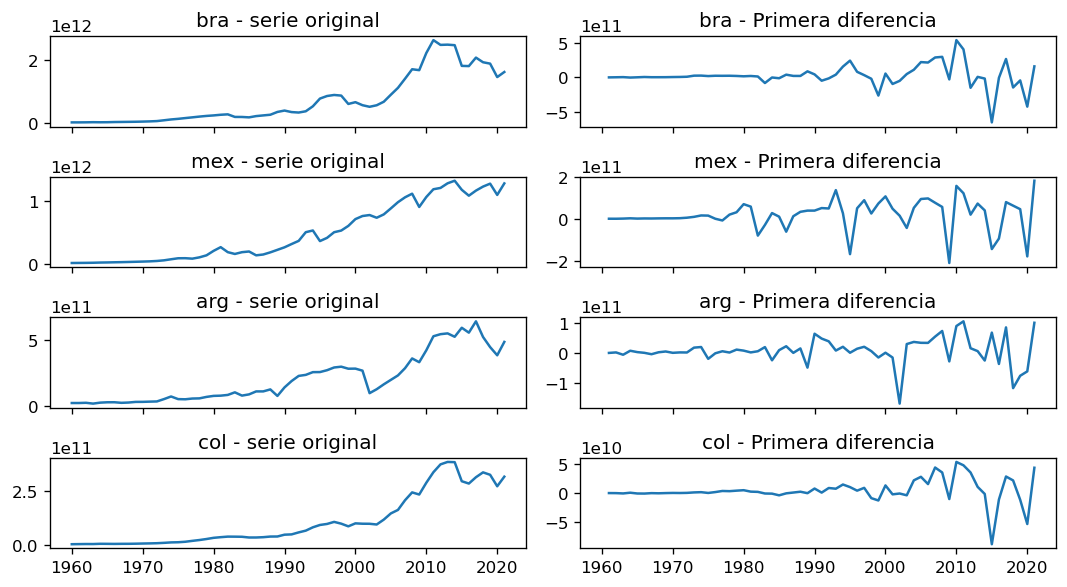

In [22]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

fig, axes = plt.subplots(len(paises), 2, sharex=True)

for i, pais in enumerate(paises):
    axes[i, 0].plot(df_original[pais])
    axes[i, 0].set_title(f'{pais} - serie original')
    axes[i, 0].set_xticks(range(0, len(df_original[pais]), 10))
    axes[i, 1].plot(df_original[pais].diff().dropna())
    axes[i, 1].set_title(f'{pais} - Primera diferencia')
    axes[i, 1].set_xticks(range(0, len(df_original[pais].diff().dropna()), 10))

fig.tight_layout()
plt.show()

Aquí podemos comparar la serie original con la serie que resulta de aplicar una diferenciación de primer orden. Al diferenciar la serie, podemos observar que en la mayoría de los casos se elimina la tendencia y se estabiliza la media, lo que sugiere que una sola diferenciación es suficiente para alcanzar la estacionariedad de la serie.

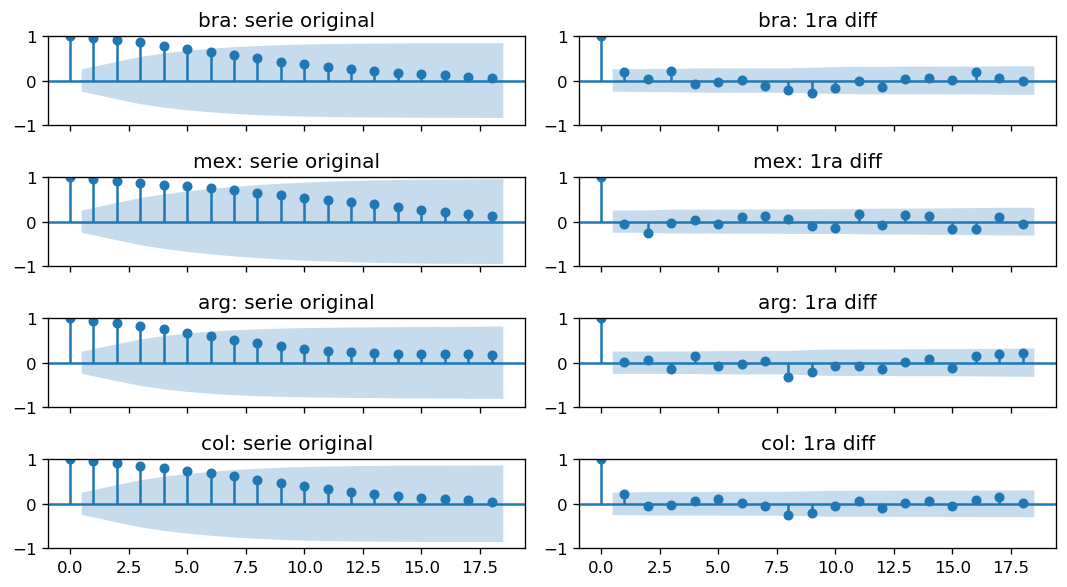

In [23]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, axes = plt.subplots(len(paises), 2, sharex=True)

for i, pais in enumerate(paises):
    # serie original
    plot_acf(df_originalperiod[pais], ax=axes[i,0])
    axes[i,0].set_title(f'{pais}: serie original')
    
    # primera diferencia
    plot_acf(df_originalperiod[pais].diff().dropna(), ax=axes[i,1])
    axes[i,1].set_title(f'{pais}: 1ra diff')

fig.tight_layout()
plt.show()

La interpretación de la gráfica ACF sugiere que, al realizar la primera diferenciación de la serie de datos, se observa que todos los rezagos de la variable convergen rápidamente al intervalo de confianza. Esto indica que la serie diferenciada no presenta una correlación serial significativa y que los valores de la serie para diferentes intervalos de tiempo son independientes entre sí.

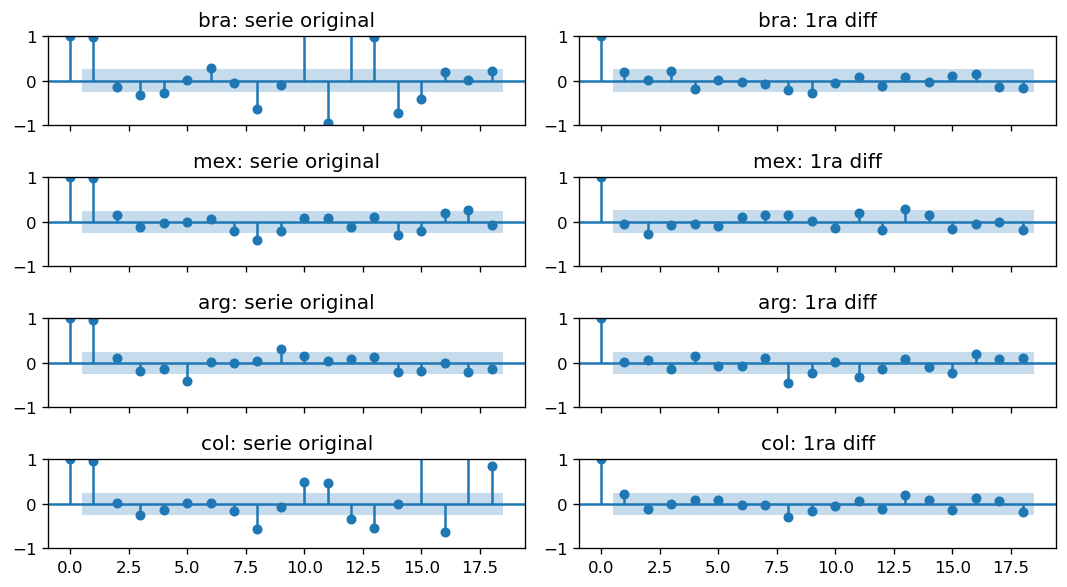

In [24]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
fig, axes = plt.subplots(len(paises), 2, sharex=True)

for i, pais in enumerate(paises):
    # serie original
    plot_pacf(df_originalperiod[pais], ax=axes[i,0])
    axes[i,0].set_title(f'{pais}: serie original')
    
    # primera diferencia
    plot_pacf(df_originalperiod[pais].diff().dropna(), ax=axes[i,1])
    axes[i,1].set_title(f'{pais}: 1ra diff')

fig.tight_layout()
plt.show();

La gráfica PACF muestra que todos los coeficientes de autocorrelación parcial son pequeños y se encuentran dentro del intervalo de confianza, esto indica que la correlación residual entre la observación actual y sus valores pasados es prácticamente nula. Esta es una buena señal para continuar con el análisis, ya que sugiere que la serie de datos se encuentra bien modelada por un proceso estocástico estacionario.

Si bien las gráficas de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) pueden ser útiles para determinar el orden de una serie de datos, se recomienda utilizar funciones más precisas y automatizadas como auto_arima para obtener resultados más precisos y confiables.

In [25]:
testsdif = []
for pais in paises:
    df_diff = df_originalperiod[pais].diff().dropna()
    testsdif.append(Tests_estadisticos(df_diff, pais))

testsdif = pd.concat(testsdif, axis=0)
testsdif.index.name = 'Estadistico'

testsdif.head()

,ADF,PP,KPSS
Estadistico,,,
bra,0.074,0.0,0.605
mex,0.000,0.0,0.169
arg,0.001,0.0,0.704
col,0.980,0.0,0.284


A grandes rasgos, al utilizar estas pruebas y comparar los tres estadísticos, podemos concluir que realizar una sola diferenciación es suficiente para obtener un buen pronóstico.

## Identificación de los órdenes p, d y q en la modelización de series de tiempo

A continuación, utilizaremos la función `auto_arima` del paquete `arq` para obtener con mayor precisión los valores óptimos de los parámetros del modelo ARIMA (p, d, q). Es importante destacar que, tras analizar las series de tiempo, hemos observado que todas ellas funcionan mejor con un orden de diferenciación de 1, lo que se reflejará en cada modelo que se ajuste.

In [26]:
def stepwise_fit(df):
    """
    Realiza un ajuste automático de un modelo ARIMA sobre los datos de la serie de timepo contenidos en el DataFrame 'df'.
    """    
    stepwise_fit = auto_arima(df, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                              start_P=0, seasonal=True, d=None, D=1, trace=True,
                              error_action='ignore', suppress_warnings=True, stepwise=True)
    
    return stepwise_fit.summary()

In [27]:
stepwise_fit(df_original['bra'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2697.865, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2705.235, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2696.108, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2703.077, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2691.793, Time=0.31 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2690.754, Time=0.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2691.840, Time=0.38 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2693.791, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2691.321, Time=0.32 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=2692.495, Time=0.21 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=2693.517, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=2692.773, Time=0.17 sec

Best model:  ARIMA(0,1,1)(1,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   62
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1342.377
Date:                             Sun, 21 May 2023   AIC                           2690.754
Time:                                     20:56:06   BIC                           2696.429
Sample:                                 01-01-1960   HQIC                          2692.907
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4508      0.203      2.225      0.026       0.054       0.848
ar.S.L12      -0.9999      0.334     -2.990      0.003      -1.655      -0.344
sigma2      5.364e+22   5.44e-24   9.86e+45      0.000    5.36e+22    5.36e+22
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                15.48
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):             105.00   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.69e+61. Standard errors may be unstable.
"""

In [28]:
stepwise_fit(df_original['mex'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2619.975, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2628.249, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2619.389, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2618.437, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2625.870, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2620.089, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2620.111, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2619.807, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2622.014, Time=0.29 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2637.914, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2620.055, Time=0.16 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2617.884, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2627.235, Time=0.04 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=2619.384, Time=0.22 sec
 ARIMA(1,1,0)(0,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   62
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1304.471
Date:                              Sun, 21 May 2023   AIC                           2616.941
Time:                                      20:56:10   BIC                           2624.508
Sample:                                  01-01-1960   HQIC                          2619.812
                                       - 01-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1031      0.158     -0.653      0.514      -0.413       0.206
ar.L2         -0.2594      0.231     -1.124      0.261      -0.711       0.193
ma.S.L12      -0.6798      0.229     -2.964      0.003      -1.129      -0.230
sigma2      9.805e+21   7.39e-23   1.33e+44      0.000    9.81e+21    9.81e+21
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 6.46
Prob(Q):                              0.77   Prob(JB):                         0.04
Heteroskedasticity (H):              13.06   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.08e+57. Standard errors may be unstable.
"""

In [29]:
stepwise_fit(df_original['arg'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2575.123, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2583.687, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2573.209, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2583.949, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2572.452, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2570.662, Time=0.10 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2572.130, Time=0.20 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.20 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2572.627, Time=0.22 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=2573.773, Time=0.35 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=2572.868, Time=0.36 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=2572.517, Time=0.06 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   62
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1282.331
Date:                             Sun, 21 May 2023   AIC                           2570.662
Time:                                     20:56:13   BIC                           2576.337
Sample:                                 01-01-1960   HQIC                          2572.815
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0229      0.215     -0.107      0.915      -0.444       0.398
ar.S.L12      -0.9514      0.208     -4.573      0.000      -1.359      -0.544
sigma2      4.653e+21   1.14e-23   4.07e+44      0.000    4.65e+21    4.65e+21
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.42
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              20.06   Skew:                            -1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.97e+60. Standard errors may be unstable.
"""

In [30]:
stepwise_fit(df_original['col'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2486.538, Time=0.14 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2494.869, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2485.901, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2490.013, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2481.587, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2479.806, Time=0.16 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2481.562, Time=0.37 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2480.760, Time=0.26 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=2483.191, Time=0.26 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=2485.098, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=2481.387, Time=0.18 sec

Best model:  ARIMA(0,1,1)(1,1,0)[

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   62
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1236.903
Date:                             Sun, 21 May 2023   AIC                           2479.806
Time:                                     20:56:16   BIC                           2485.482
Sample:                                 01-01-1960   HQIC                          2481.960
                                      - 01-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4287      0.212      2.018      0.044       0.012       0.845
ar.S.L12      -0.9999      0.351     -2.847      0.004      -1.688      -0.311
sigma2      6.863e+20   3.23e-22   2.12e+42      0.000    6.86e+20    6.86e+20
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                78.97
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):             244.00   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.56e+57. Standard errors may be unstable.
"""

Los modelos arrojados son los siguientes
1. Brasil : SARIMAX(0,1,1)(1,1,0,12)
2. Mexico : SARIMAX(2,1,0)(0,1,1,12)
3. Argentinca : SARIMAX(0,1,1)(0,1,1,12)
4. Colombia : SARIMAX(0,1,1)(1,1,0,12)

## Entrenamiento del modelo

Se procederá a realizar la estimación del modelo y a obtener un resumen del mismo mediante la función `SARIMAX` de la biblioteca `Statsmodels`. Con esta herramienta, podremos ajustar un modelo SARIMAX a nuestros datos y obtener información resumida sobre el modelo estimado, como sus parámetros, el ajuste a los datos y las estadísticas de diagnóstico

In [31]:
modbra = SARIMAX(df_train['bra'],order = (0, 1, 1), 
                seasonal_order =(1, 1, [], 12))
resbra = modbra.fit()
print(resbra.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 bra   No. Observations:                   54
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1111.196
Date:                             Sun, 21 May 2023   AIC                           2228.392
Time:                                     20:56:17   BIC                           2233.533
Sample:                                 12-31-1960   HQIC                          2230.264
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6164      0.236      2.615      0.009       0.154       1.078
ar.S.L12      -1.0000      

In [32]:
modmex = SARIMAX(df_train['mex'],order = (2, 1, 0), 
                seasonal_order =(0, 1, [1], 12))
resmex = modmex.fit()
print(resmex.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  mex   No. Observations:                   54
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood               -1083.469
Date:                              Sun, 21 May 2023   AIC                           2174.939
Time:                                      20:56:17   BIC                           2181.793
Sample:                                  12-31-1960   HQIC                          2177.435
                                       - 12-31-2013                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0053      0.132      0.040      0.968      -0.254       0.264
ar.L2         -0.35

In [33]:
modarg = SARIMAX(df_train['arg'],order = (0, 1, 1), 
                seasonal_order =(0, 1, [1], 12))
resarg = modarg.fit()
print(resarg.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                arg   No. Observations:                   54
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1065.745
Date:                            Sun, 21 May 2023   AIC                           2137.489
Time:                                    20:56:17   BIC                           2142.630
Sample:                                12-31-1960   HQIC                          2139.361
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1026      0.205      0.501      0.616      -0.299       0.504
ma.S.L12      -0.6397      0.203   

In [34]:
modcol = SARIMAX(df_train['col'],order = (0, 1, 1), 
                seasonal_order =(1, 1, [0], 12))
rescol = modcol.fit()
print(rescol.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 col   No. Observations:                   54
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood               -1018.928
Date:                             Sun, 21 May 2023   AIC                           2043.855
Time:                                     20:56:17   BIC                           2048.996
Sample:                                 12-31-1960   HQIC                          2045.727
                                      - 12-31-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5411      0.195      2.775      0.006       0.159       0.923
ar.S.L12      -0.9999      

## **Pronosticos**

In [35]:
df_originalperiod.index = df_originalperiod.index.to_timestamp()
df_train.index = df_train.index.to_timestamp()
df_test.index = df_test.index.to_timestamp()

In [36]:
# Crear figura
fig = make_subplots(rows=1, cols=1)
# Añadir gráfico de línea para Brasil
fig.add_trace(go.Scatter(x=df_originalperiod.index, y=df_originalperiod['bra'], mode='lines', name='Brasil'))
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['bra'], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['bra'], mode='lines', name='test'))
# Añadir predicciones
fcastbra = resbra.get_forecast('2026').summary_frame()
fcastbra.index = fcastbra.index.to_timestamp()
fig.add_trace(go.Scatter(x=fcastbra.index, y=fcastbra['mean'], mode='lines', name='Predicción'))
fig.add_trace(go.Scatter(x=fcastbra.index, y=fcastbra['mean_ci_upper'], mode='lines', name='Intervalo de confianza superior', fill='tonexty'))
fig.add_trace(go.Scatter(x=fcastbra.index, y=fcastbra['mean_ci_lower'], mode='lines', name='Intervalo de confianza inferior', fill='tonexty'))
# Ajustal el rango del eje x de la grafica
fig.update_xaxes(range=['2000-01-01', '2026-01-01'])
# Configurar diseño
fig.update_layout(title='PIB de Brasil (2000-2023)', xaxis_title='Año', yaxis_title='PIB (en dólares)', hovermode='x')
# Mostrar figura
fig.show();

Para observar la grafica sin ejecutar el codigo dirigase al siguiente link

[Pronostico PIB Brasil](https://github.com/juanguzman2/Proyecto1/blob/master/Imagenes/PibBrasil.png)

In [37]:
# Crear figura
fig = make_subplots(rows=1, cols=1)
# Añadir gráfico de línea para Mexico
fig.add_trace(go.Scatter(x=df_originalperiod.index, y=df_originalperiod['mex'], mode='lines', name='Mexico'))
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['mex'], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['mex'], mode='lines', name='test'))
# Añadir predicciones
fcastmex = resmex.get_forecast('2026').summary_frame()
fcastmex.index = fcastmex.index.to_timestamp()
fig.add_trace(go.Scatter(x=fcastmex.index, y=fcastmex['mean'], mode='lines', name='Predicción'))
fig.add_trace(go.Scatter(x=fcastmex.index, y=fcastmex['mean_ci_upper'], mode='lines', name='Intervalo de confianza superior', fill='tonexty'))
fig.add_trace(go.Scatter(x=fcastmex.index, y=fcastmex['mean_ci_lower'], mode='lines', name='Intervalo de confianza inferior', fill='tonexty'))
# Ajustal el rango del eje x de la grafica
fig.update_xaxes(range=['2000-01-01', '2026-01-01'])
# Configurar diseño
fig.update_layout(title='PIB de Mexico (2000-2023)', xaxis_title='Año', yaxis_title='PIB (en dólares)', hovermode='x')
# Mostrar figura
fig.show();

Para observar la grafica sin ejecutar el codigo dirigase al siguiente link

[Pronostico PIB Mexico](https://github.com/juanguzman2/Proyecto1/blob/master/Imagenes/PibMexico.png)

In [38]:
# Crear figura
fig = make_subplots(rows=1, cols=1)
# Añadir gráfico de línea para Argentina
fig.add_trace(go.Scatter(x=df_originalperiod.index, y=df_originalperiod['arg'], mode='lines', name='Argentina'))
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['arg'], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['arg'], mode='lines', name='test'))
# Añadir predicciones
fcastarg = resarg.get_forecast('2026').summary_frame()
fcastarg.index = fcastarg.index.to_timestamp()
fig.add_trace(go.Scatter(x=fcastarg.index, y=fcastarg['mean'], mode='lines', name='Predicción'))
fig.add_trace(go.Scatter(x=fcastarg.index, y=fcastarg['mean_ci_upper'], mode='lines', name='Intervalo de confianza superior', fill='tonexty'))
fig.add_trace(go.Scatter(x=fcastarg.index, y=fcastarg['mean_ci_lower'], mode='lines', name='Intervalo de confianza inferior', fill='tonexty'))
# Ajustal el rango del eje x de la grafica
fig.update_xaxes(range=['2000-01-01', '2026-01-01'])
# Configurar diseño
fig.update_layout(title='PIB de Argentina (2000-2023)', xaxis_title='Año', yaxis_title='PIB (en dólares)', hovermode='x')
# Mostrar figura
fig.show();

Para observar la grafica sin ejecutar el codigo dirigase al siguiente link

[Pronostico PIB Argentina](https://github.com/juanguzman2/Proyecto1/blob/master/Imagenes/PibArgentina.png)

In [39]:
# Crear figura
fig = make_subplots(rows=1, cols=1)
# Añadir gráfico de línea para Colombia
fig.add_trace(go.Scatter(x=df_originalperiod.index, y=df_originalperiod['col'], mode='lines', name='Colombia'))
fig.add_trace(go.Scatter(x=df_train.index, y=df_train['col'], mode='lines', name='train'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['col'], mode='lines', name='test'))
# Añadir predicciones
fcastcol = rescol.get_forecast('2026').summary_frame()
fcastcol.index = fcastcol.index.to_timestamp()
fig.add_trace(go.Scatter(x=fcastcol.index, y=fcastcol['mean'], mode='lines', name='Predicción'))
fig.add_trace(go.Scatter(x=fcastcol.index, y=fcastcol['mean_ci_upper'], mode='lines', name='Intervalo de confianza superior', fill='tonexty'))
fig.add_trace(go.Scatter(x=fcastcol.index, y=fcastcol['mean_ci_lower'], mode='lines', name='Intervalo de confianza inferior', fill='tonexty'))
# Ajustal el rango del eje x de la grafica
fig.update_xaxes(range=['2000-01-01', '2026-01-01'])
# Configurar diseño
fig.update_layout(title='PIB de Colombia (2000-2023)', xaxis_title='Año', yaxis_title='PIB (en dólares)', hovermode='x')
# Mostrar figura
fig.show();

Para observar la grafica sin ejecutar el codigo dirigase al siguiente link

[Pronostico PIB Colombia](https://github.com/juanguzman2/Proyecto1/blob/master/Imagenes/PibColombia.png)

## Evaluar el modelo mediante MSE y RMSE



In [40]:
forecasts = [resbra.forecast(), resmex.forecast(), resarg.forecast(), rescol.forecast()]
test_data = [df_test[pais] for pais in paises]
for pais, forecast, data in zip(paises, forecasts, test_data):
    rmse_value = round(rmse(data, forecast))
    mse_value = mse(data, forecast)
    print(f"El rmse y mse para {pais} es: {rmse_value}, {mse_value}")

El rmse y mse para bra es: 728679775703, 5.309742155189954e+23
El rmse y mse para mex es: 141157525995, 1.9925447145148507e+22
El rmse y mse para arg es: 77689486957, 6.035656383672728e+21
El rmse y mse para col es: 81463485493, 6.636299468729627e+21
